# Data preprocessing

## Dataset Harmonization and label normalization

In [1]:
from pathlib import Path
import shutil
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(42)

In [2]:
RAW_DIR = Path("../data/raw")
PROCESSED_DIR = Path("../data/processed")

RAF_DIR = RAW_DIR / "RAF-DB"
AFFECTNET_DIR = RAW_DIR / "AffectNet/YOLO_format"
KDEF_DIR = RAW_DIR / "KDEF/KDEF_and_AKDEF/KDEF"


In [15]:
EMOTION_MAP = {
    "surprised": 0,
    "fear": 1,
    "disgust": 2,
    "happy": 3,
    "sad": 4,
    "angry": 5,
    "neutral": 6,
}

RAF_MAP = {
    1: "surprised",
    2: "fear",
    3: "disgust",
    4: "happy",
    5: "sad",
    6: "angry",
    7: "neutral",
}

DATASET_MAP = {
    "1": "surprised",
    "2": "fear",
    "3": "disgust",
    "4": "happy",
    "5": "sad",
    "6": "angry",
    "7": "neutral",
}

AFFECTNET_MAP = {
    0: "angry",
    2: "disgust",
    3: "fear",
    4: "happy",
    5: "neutral",
    6: "sad",
    7: "surprised",
}

KDEF_MAP = {
    "SU": "surprised",
    "AF": "fear",
    "DI": "disgust",
    "HA": "happy",
    "SA": "sad",
    "AN": "angry",
    "NE": "neutral",
}


In [16]:
if PROCESSED_DIR.exists():
    shutil.rmtree(PROCESSED_DIR)

for split in ["train", "val", "test"]:
    for i in range(7):
        (PROCESSED_DIR / split / str(i)).mkdir(parents=True, exist_ok=True)


In [17]:
def copy_image(src, emotion, split):
    dst = PROCESSED_DIR / split / str(EMOTION_MAP[emotion]) / src.name
    shutil.copy2(src, dst)


def stratified_split(items, train_ratio=0.8, val_ratio=0.1):
    """
    items : list of (Path, emotion)
    """
    by_class = {}

    for img, emo in items:
        by_class.setdefault(emo, []).append(img)

    splits = {"train": [], "val": [], "test": []}

    for emo, imgs in by_class.items():
        random.shuffle(imgs)
        n = len(imgs)

        n_train = int(n * train_ratio)
        n_val = int(n * val_ratio)

        splits["train"] += [(img, emo) for img in imgs[:n_train]]
        splits["val"] += [(img, emo) for img in imgs[n_train:n_train + n_val]]
        splits["test"] += [(img, emo) for img in imgs[n_train + n_val:]]

    return splits


In [ ]:
def process_rafdb_dataset():
    all_items = []

    #RAF-DB CSV
    images_dir = RAF_DIR / "images"
    for csv_name in ["train_labels.csv", "test_labels.csv"]:
        df = pd.read_csv(RAF_DIR / csv_name)
        for _, row in df.iterrows():
            label = int(row["label"])
            if label not in RAF_MAP:
                continue
            img = images_dir / row["image"]
            if not img.exists():
                continue
            all_items.append((img, RAF_MAP[label]))

    #DATASET subfolders
    dataset_dir = RAF_DIR / "DATASET"
    for split_dir in ["train", "test"]:
        for class_dir in (dataset_dir / split_dir).iterdir():
            emo = DATASET_MAP[class_dir.name]
            for img in class_dir.glob("*"):
                all_items.append((img, emo))

    print(len(all_items))
    #Stratified split 80/10/10
    splits = stratified_split(all_items)

    for split, items in splits.items():
        for img, emo in items:
            copy_image(img, emo, split)

process_rafdb_dataset()


15339


In [19]:
def process_affectnet():
    all_items = []
    

    for split in ["train", "valid", "test"]:
        images_dir = AFFECTNET_DIR / split / "images"
        labels_dir = AFFECTNET_DIR / split / "labels"

        for label_file in labels_dir.glob("*.txt"):
            with open(label_file) as f:
                class_id = int(f.readline().split()[0])

            if class_id not in AFFECTNET_MAP:
                continue

            img = images_dir / f"{label_file.stem}.png"
            if not img.exists():
                img = images_dir / f"{label_file.stem}.jpg"
            if not img.exists():
                continue

            all_items.append((img, AFFECTNET_MAP[class_id]))

    print(len(all_items))
    splits = stratified_split(all_items)

    for split, items in splits.items():
        for img, emo in items:
            copy_image(img, emo, split)

process_affectnet()


22316


In [20]:
def process_kdef():
    all_items = []

    for subject_dir in KDEF_DIR.iterdir():
        if not subject_dir.name.startswith("A"):
            continue

        for img in subject_dir.glob("*.JPG"):
            code = img.stem
            emotion_code = code[4:6]
            angle = code[6:8]

            if emotion_code not in KDEF_MAP:
                continue
            if angle not in ["S", "HL", "HR"]:
                continue

            all_items.append((img, KDEF_MAP[emotion_code]))

    print(len(all_items))
    splits = stratified_split(all_items)

    for split, items in splits.items():
        for img, emo in items:
            copy_image(img, emo, split)

process_kdef()


1468


## Face alignment

In [ ]:
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
import math
import os
import shutil
from tqdm import tqdm
from pathlib import Path


detector = MTCNN()
IMG_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}

def is_image(file_path):
    return Path(file_path).suffix.lower() in IMG_EXT

def align_face(image):
    results = detector.detect_faces(image)
    if len(results) == 0:
        return None
    
    keypoints = results[0]['keypoints']
    left_eye = keypoints['left_eye']
    right_eye = keypoints['right_eye']
    
    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = math.degrees(math.atan2(dy, dx))
    
    eyes_center = (
        int((left_eye[0] + right_eye[0]) / 2),
        int((left_eye[1] + right_eye[1]) / 2)
    )
    
    M = cv2.getRotationMatrix2D(eyes_center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))
    
    # Crop
    x, y, w, h = results[0]['box']
    padding = 0.3
    x_new = max(0, int(x - w * padding))
    y_new = max(0, int(y - h * padding))
    w_new = int(w * (1 + 2 * padding))
    h_new = int(h * (1 + 2 * padding))
    
    cropped = rotated[y_new:y_new+h_new, x_new:x_new+w_new]
    
    # Resizing
    aligned_face = cv2.resize(cropped, (224, 224))
    
    return aligned_face

def align_dataset(src_root, dst_root):
    src_root = Path(src_root)
    dst_root = Path(dst_root)
    dst_root.mkdir(parents=True, exist_ok=True)
    
    for split_dir in ["train", "val", "test"]:
        for class_dir in (src_root / split_dir).iterdir():
            if not class_dir.is_dir():
                continue
            dst_class_dir = dst_root / split_dir / class_dir.name
            dst_class_dir.mkdir(parents=True, exist_ok=True)
            
            for img_path in tqdm(list(class_dir.glob("*")), desc=f"Aligning {split_dir}/{class_dir.name}"):
                if not is_image(img_path):
                    continue
                
                img = cv2.imread(str(img_path))
                if img is None:
                    print(f"[WARNING] Cannot read image: {img_path}")
                    continue
                
                aligned = align_face(img)
                if aligned is None:
                    # fallback = resize original
                    aligned = cv2.resize(img, (224, 224))
                
                dst_file = dst_class_dir / img_path.name
                cv2.imwrite(str(dst_file), aligned)

SRC_FOLDER = "../data/processed"   
DST_FOLDER = "../data/aligned"    

align_dataset(SRC_FOLDER, DST_FOLDER)


Aligning test/6: 100%|██████████| 580/580 [01:27<00:00,  6.62it/s]


## Creation of metadata file

In [3]:
EMOTION_LABELS = {
    0: "surprised",
    1: "fear",
    2: "disgust",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "neutral",
}

In [23]:
def get_capture_condition(filename: str) -> str:
    return "studio" if filename.startswith("A") else "wild"


In [24]:
def infer_dataset_source(filename: str) -> str:
    if filename.startswith("A"):
        return "KDEF"
    if "aligned" in filename.lower():
        return "RAF-DB"
    else:
        return "Affectnet"


In [25]:
def build_metadata_csv(root_dir: Path, output_csv: Path):
    records = []

    for split in ["train", "val", "test"]:
        split_dir = root_dir / split
        for class_dir in split_dir.iterdir():
            if not class_dir.is_dir():
                continue

            class_id = int(class_dir.name)
            emotion = EMOTION_LABELS[class_id]

            for img_path in class_dir.glob("*"):
                records.append({
                    "filepath": str(img_path),
                    "filename": img_path.name,
                    "split": split,
                    "class_id": class_id,
                    "emotion": emotion,
                    "condition": get_capture_condition(img_path.name),
                    "source": infer_dataset_source(img_path.name),
                })

    df = pd.DataFrame(records)
    df.to_csv(output_csv, index=False)

    print(f"Metadata CSV created: {output_csv}")
    print(f"Total images: {len(df)}")

    return df


In [26]:
ALIGNED_DIR = Path("../data/aligned")
METADATA_PATH = ALIGNED_DIR / "metadata.csv"

metadata_df = build_metadata_csv(ALIGNED_DIR, METADATA_PATH)
metadata_df.head()


Metadata CSV created: ..\data\aligned\metadata.csv
Total images: 41304


,filepath,filename,split,class_id,emotion,condition,source
0,..\data\aligned\train\0\AF01SUHR.JPG,AF01SUHR.JPG,train,0,surprised,studio,KDEF
1,..\data\aligned\train\0\AF01SUS.JPG,AF01SUS.JPG,train,0,surprised,studio,KDEF
2,..\data\aligned\train\0\AF02SUHL.JPG,AF02SUHL.JPG,train,0,surprised,studio,KDEF
3,..\data\aligned\train\0\AF02SUHR.JPG,AF02SUHR.JPG,train,0,surprised,studio,KDEF
4,..\data\aligned\train\0\AF02SUS.JPG,AF02SUS.JPG,train,0,surprised,studio,KDEF


      emotion  split  count
0       angry   test    515
1       angry  train   3720
2       angry    val    512
3     disgust   test    504
4     disgust  train   3576
5     disgust    val    503
6        fear   test    387
7        fear  train   2877
8        fear    val    384
9       happy   test   1071
10      happy  train   7796
11      happy    val   1070
12    neutral   test    717
13    neutral  train   4885
14    neutral    val    714
15        sad   test    616
16        sad  train   4489
17        sad    val    614
18  surprised   test    705
19  surprised  train   4947
20  surprised    val    702


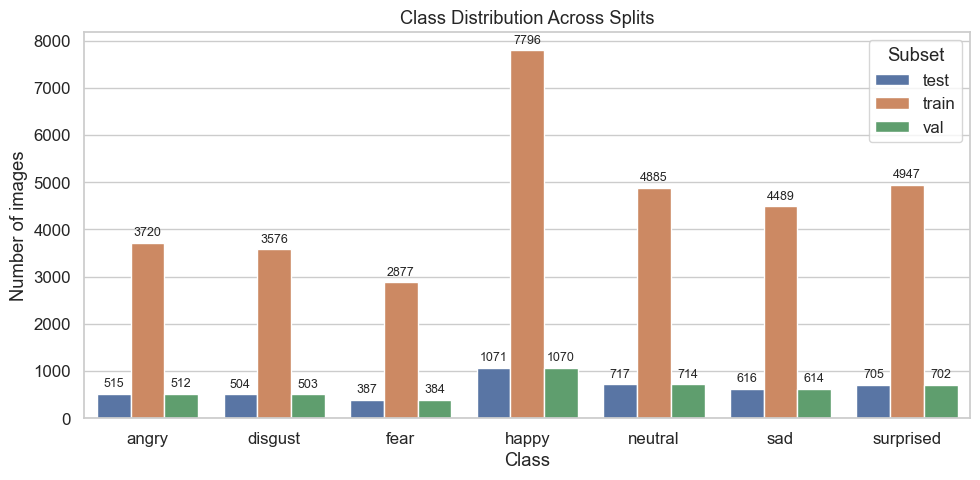

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load metadata
metadata = pd.read_csv("../data/aligned/metadata.csv")
metadata["emotion"] = metadata["class_id"].map(EMOTION_LABELS)

counts = (
    metadata
    .groupby(["emotion", "split"])
    .size()
    .reset_index(name="count")
)

print(counts)

sns.set_theme(style="whitegrid", font_scale=1.1)

plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=counts,
    x="emotion",
    y="count",
    hue="split"
)

ax.set_xlabel("Class")
ax.set_ylabel("Number of images")
ax.set_title("Class Distribution Across Splits")

for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=3, fontsize=9)

ax.legend(title="Subset")

plt.tight_layout()
plt.show()


      source  split  count
0  Affectnet   test   2690
1  Affectnet  train  18612
2  Affectnet    val   2695
3       KDEF   test    285
4       KDEF  train   1409
5       KDEF    val    274
6     RAF-DB   test   1540
7     RAF-DB  train  12269
8     RAF-DB    val   1530


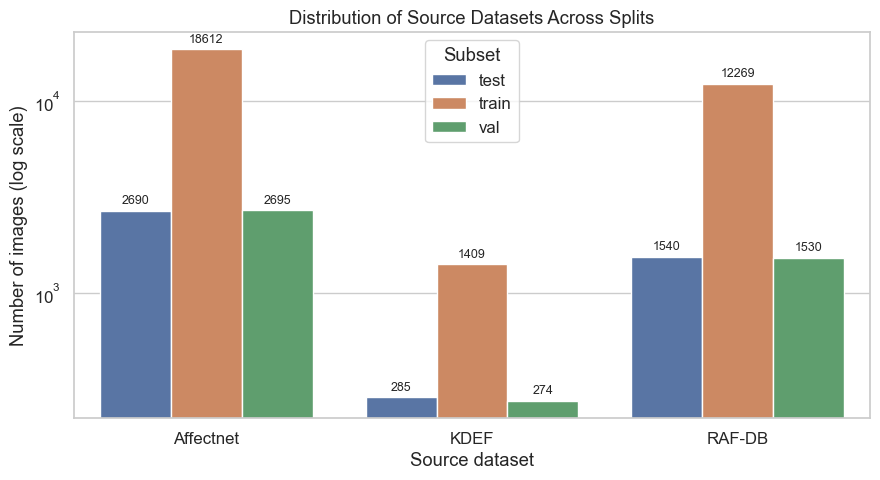

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load metadata
metadata = pd.read_csv("../data/aligned/metadata.csv")

# Count samples per source and split
counts = (
    metadata
    .groupby(["source", "split"])
    .size()
    .reset_index(name="count")
)

print(counts)

# Seaborn style
sns.set_theme(style="whitegrid", font_scale=1.1)

# Plot
plt.figure(figsize=(9, 5))
ax = sns.barplot(
    data=counts,
    x="source",
    y="count",
    hue="split"
)

# Log scale on Y axis
ax.set_yscale("log")

# Labels and title
ax.set_xlabel("Source dataset")
ax.set_ylabel("Number of images (log scale)")
ax.set_title("Distribution of Source Datasets Across Splits")

# Annotate bars (works well even in log scale)
for container in ax.containers:
    ax.bar_label(container, fmt="%d", padding=3, fontsize=9)

# Legend
ax.legend(title="Subset")

# Layout
plt.tight_layout()
plt.show()


### Anomalies detection

In [27]:
DATASET_PATH = Path("../data/aligned")
TRAIN_PATH = DATASET_PATH / "train"
VAL_PATH = DATASET_PATH / "val"
TEST_PATH = DATASET_PATH / "test"

In [28]:
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm import tqdm

IMAGE_EXTS = {".jpg", ".jpeg", ".png"}

def detect_image_anomalies(
    root_path,
    var_threshold=5.0,
    dark_threshold=20,
    bright_threshold=235,
):
    """
    Détecte les anomalies dans un dataset d'images.
    Retourne un dictionnaire avec les chemins suspects.
    """

    root_path = Path(root_path)

    anomalies = {
        "corrupted": [],
        "low_variance": [],
        "too_dark": [],
        "too_bright": [],
    }

    image_paths = [
        p for p in root_path.rglob("*")
        if p.is_file() and p.suffix.lower() in IMAGE_EXTS
    ]

    for img_path in tqdm(image_paths, desc="Analyse des images"):
        try:
            img = Image.open(img_path).convert("L")
            arr = np.array(img)

            mean_val = arr.mean()
            var_val = arr.var()

            if var_val < var_threshold:
                anomalies["low_variance"].append(img_path)

            if mean_val < dark_threshold:
                anomalies["too_dark"].append(img_path)

            if mean_val > bright_threshold:
                anomalies["too_bright"].append(img_path)

        except Exception:
            anomalies["corrupted"].append(img_path)

    return anomalies


In [29]:
anomalies = detect_image_anomalies(DATASET_PATH)

for k, v in anomalies.items():
    print(f"{k}: {len(v)} images")


Analyse des images: 100%|██████████| 41304/41304 [07:44<00:00, 88.93it/s] 

corrupted: 0 images
low_variance: 0 images
too_dark: 9 images
too_bright: 1 images


In [33]:
import matplotlib.pyplot as plt

def show_anomalies(anomaly_list, n=8):
    plt.figure(figsize=(12, 3))
    for i, img_path in enumerate(anomaly_list[:n]):
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(img_path.parent.name)
    plt.show()


In [31]:
show_anomalies(anomalies["corrupted"])

<Figure size 1200x300 with 0 Axes>

In [34]:
show_anomalies(anomalies["low_variance"])

<Figure size 1200x300 with 0 Axes>

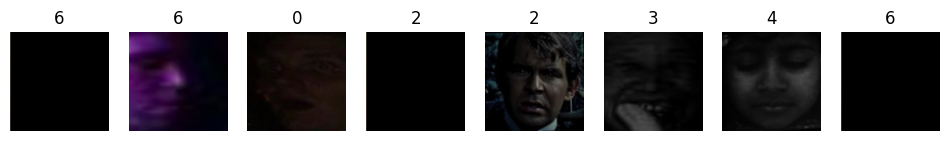

In [35]:
show_anomalies(anomalies["too_dark"])

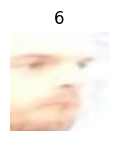

In [36]:
show_anomalies(anomalies["too_bright"])

In [37]:
# Delete anomalies
def delete_anomalies(anomalies):
    """
    Supprime définitivement les images anomalies.
    """
    for paths in anomalies.values():
        for img_path in paths:
            if img_path.exists():
                img_path.unlink()
delete_anomalies(anomalies)

## FER-2013 test preparation

In [12]:
import shutil
from pathlib import Path
from tqdm import tqdm

FER_MAP = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "neutral",
    5: "sad",
    6: "surprise",
}

EMOTION_LABELS = {
    0: "surprise",
    1: "fear",
    2: "disgust",
    3: "happy",
    4: "sad",
    5: "angry",
    6: "neutral",
}


def build_fer_to_emotion_mapping():
    inverse_emotion = {v: k for k, v in EMOTION_LABELS.items()}
    fer_to_emotion = {}

    for fer_idx, fer_name in FER_MAP.items():
        if fer_name not in inverse_emotion:
            raise ValueError(f"Classe FER inconnue dans EMOTION_LABELS: {fer_name}")
        fer_to_emotion[fer_idx] = inverse_emotion[fer_name]

    return fer_to_emotion


def reorganize_fer2013_test(
    fer_test_path: str,
    output_path: str,
    copy: bool = True,
):
    fer_test_path = Path(fer_test_path)
    output_path = Path(output_path) / "test_fer_2013"
    output_path.mkdir(parents=True, exist_ok=True)

    fer_to_emotion = build_fer_to_emotion_mapping()

    for idx in range(7):
        (output_path / str(idx)).mkdir(exist_ok=True)

    print("FER → EMOTION mapping:", fer_to_emotion)

    for fer_idx, fer_name in FER_MAP.items():
        src_dir = fer_test_path / fer_name
        if not src_dir.exists():
            raise FileNotFoundError(f"Dossier manquant: {src_dir}")

        target_idx = fer_to_emotion[fer_idx]
        dst_dir = output_path / str(target_idx)

        images = list(src_dir.glob("*"))
        print(f"{fer_name} → {target_idx} ({len(images)} images)")

        for img_path in tqdm(images, desc=f"Processing {fer_name}"):
            dst_path = dst_dir / img_path.name
            if copy:
                shutil.copy2(img_path, dst_path)
            else:
                shutil.move(img_path, dst_path)

    print("Label noramlization finished")


In [13]:
reorganize_fer2013_test(
    fer_test_path="../data/raw/FER-2013/test",
    output_path="../data/processed",
    copy=True
)


FER → EMOTION mapping: {0: 5, 1: 2, 2: 1, 3: 3, 4: 6, 5: 4, 6: 0}
angry → 5 (958 images)


Processing angry: 100%|██████████| 958/958 [00:00<00:00, 1560.58it/s]


disgust → 2 (111 images)


Processing disgust: 100%|██████████| 111/111 [00:00<00:00, 1553.22it/s]


fear → 1 (1024 images)


Processing fear: 100%|██████████| 1024/1024 [00:00<00:00, 1489.49it/s]


happy → 3 (1774 images)


Processing happy: 100%|██████████| 1774/1774 [00:01<00:00, 1453.24it/s]


neutral → 6 (1233 images)


Processing neutral: 100%|██████████| 1233/1233 [00:00<00:00, 1554.68it/s]


sad → 4 (1247 images)


Processing sad: 100%|██████████| 1247/1247 [00:00<00:00, 1516.54it/s]


surprise → 0 (831 images)


Processing surprise: 100%|██████████| 831/831 [00:17<00:00, 48.81it/s]

Label noramlization finished


In [14]:
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
import math
from tqdm import tqdm
from pathlib import Path

# ==================================
# CONFIG
# ==================================
IMG_EXT = {'.jpg', '.jpeg', '.png', '.bmp', '.webp'}
TARGET_SIZE = (224, 224)

# Détecteur visage
detector = MTCNN()


# ==================================
# UTILS
# ==================================
def is_image(file_path):
    return Path(file_path).suffix.lower() in IMG_EXT


def gray_to_rgb(img):
    """
    img: grayscale or BGR
    return: RGB (3 channels)
    """
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    elif img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    return img


def align_face(image):
    """
    image: BGR image (OpenCV)
    """
    results = detector.detect_faces(image)
    if len(results) == 0:
        return None

    face = results[0]

    # Yeux
    left_eye = face['keypoints']['left_eye']
    right_eye = face['keypoints']['right_eye']

    dy = right_eye[1] - left_eye[1]
    dx = right_eye[0] - left_eye[0]
    angle = math.degrees(math.atan2(dy, dx))

    eyes_center = (
        int((left_eye[0] + right_eye[0]) / 2),
        int((left_eye[1] + right_eye[1]) / 2)
    )

    M = cv2.getRotationMatrix2D(eyes_center, angle, 1.0)
    rotated = cv2.warpAffine(
        image, M, (image.shape[1], image.shape[0])
    )

    # Crop visage
    x, y, w, h = face['box']
    padding = 0.3

    x_new = max(0, int(x - w * padding))
    y_new = max(0, int(y - h * padding))
    w_new = int(w * (1 + 2 * padding))
    h_new = int(h * (1 + 2 * padding))

    cropped = rotated[y_new:y_new+h_new, x_new:x_new+w_new]
    aligned_face = cv2.resize(cropped, TARGET_SIZE)

    return aligned_face


# ==================================
# MAIN
# ==================================
def align_fer2013_test(
    src_root: str,
    dst_root: str,
):
    src_root = Path(src_root)
    dst_root = Path(dst_root)
    dst_root.mkdir(parents=True, exist_ok=True)

    for class_dir in sorted(src_root.iterdir()):
        if not class_dir.is_dir():
            continue

        dst_class_dir = dst_root / class_dir.name
        dst_class_dir.mkdir(parents=True, exist_ok=True)

        images = list(class_dir.glob("*"))
        print(f"Processing class {class_dir.name} ({len(images)} images)")

        for img_path in tqdm(images, desc=f"Aligning class {class_dir.name}"):
            if not is_image(img_path):
                continue

            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"[WARNING] Cannot read image: {img_path}")
                continue

            # Grayscale → RGB
            img = gray_to_rgb(img)

            aligned = align_face(img)
            if aligned is None:
                # fallback : resize simple
                aligned = cv2.resize(img, TARGET_SIZE)

            dst_file = dst_class_dir / img_path.name
            cv2.imwrite(str(dst_file), aligned)

    print("FER-2013 test alignment complete")


In [15]:
align_fer2013_test(
    src_root="../data/processed/test_fer_2013",
    dst_root="../data/aligned/test_fer_2013"
)


Processing class 0 (831 images)


Aligning class 0: 100%|██████████| 831/831 [01:51<00:00,  7.43it/s]


Processing class 1 (1024 images)


Aligning class 1: 100%|██████████| 1024/1024 [03:09<00:00,  5.39it/s]


Processing class 2 (111 images)


Aligning class 2: 100%|██████████| 111/111 [00:20<00:00,  5.48it/s]


Processing class 3 (1774 images)


Aligning class 3: 100%|██████████| 1774/1774 [06:01<00:00,  4.91it/s]


Processing class 4 (1247 images)


Aligning class 4: 100%|██████████| 1247/1247 [04:31<00:00,  4.60it/s]


Processing class 5 (958 images)


Aligning class 5: 100%|██████████| 958/958 [03:05<00:00,  5.17it/s]


Processing class 6 (1233 images)


Aligning class 6: 100%|██████████| 1233/1233 [02:23<00:00,  8.60it/s]

FER-2013 test alignment complete


## Creation of an extract of the dataset with only RAF-DB and KDEF

In [2]:
import csv
import shutil
from pathlib import Path

METADATA_PATH = Path("../data/aligned/metadata.csv")
SRC_ROOT = Path("../data/aligned")
DST_ROOT = Path("../data/aligned_extract")
ALLOWED_SOURCES = {"KDEF", "RAF-DB"}

for split in ["train", "val", "test"]:
    for class_id in map(str, range(7)):
        (DST_ROOT / split / class_id).mkdir(parents=True, exist_ok=True)


with METADATA_PATH.open(newline="", encoding="utf-8") as f:
    reader = csv.DictReader(f)

    for row in reader:
        if row["source"] not in ALLOWED_SOURCES:
            continue

        split = row["split"]          # train / val / test
        class_id = row["class_id"]    # 0..6
        filename = row["filename"]    # AF01SUHR.JPG

        src_path = SRC_ROOT / split / class_id / filename
        dst_path = DST_ROOT / split / class_id / filename

        if not src_path.exists():
            print(f"[WARNING] Fichier manquant : {src_path}")
            continue

        shutil.copy2(src_path, dst_path)

print("Extraction ended with success")


[WARNING] Fichier manquant : ..\data\aligned\train\0\train_03050_aligned.jpg
[WARNING] Fichier manquant : ..\data\aligned\train\2\AF20DIHL.JPG
[WARNING] Fichier manquant : ..\data\aligned\train\3\train_00537_aligned.jpg
[WARNING] Fichier manquant : ..\data\aligned\train\4\test_1584_aligned.jpg
[WARNING] Fichier manquant : ..\data\aligned\train\6\AF11NEHL.JPG
[WARNING] Fichier manquant : ..\data\aligned\train\6\train_09789_aligned.jpg
[WARNING] Fichier manquant : ..\data\aligned\test\6\AF11NEHL.JPG
[WARNING] Fichier manquant : ..\data\aligned\test\6\train_09880_aligned.jpg
[WARNING] Fichier manquant : ..\data\aligned\test\6\train_10349_aligned.jpg
Extraction ended with success
